In [1]:
# Cell 1: Introduction and Imports
# ASVspoof2021 DF Evaluation Notebook
# Analysis of scores from SSL_Anti-spoofing model on ASVspoof2021 DF evaluation dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
from sklearn.metrics import roc_curve, auc

# Import functions from our eval_metrics.py
sys.path.append('.')  # Make sure the current directory is in the path
from eval_metrics import (
    compute_det_curve, compute_eer, compute_min_dcf,
    load_asvspoof_scores, is_asvspoof_format, compute_metrics
)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.2)

# Define plot parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
# Cell 2: Load and Evaluate ASVspoof Format Scores

# File paths for SSL_Anti-spoofing model scores on ASVspoof2021 DF eval
asvspoof_score_file = "../files/eval_asvspoof_new_scores.txt"
cm_key_file = "../files/trial_metadata.txt"
phase = "eval"

print("Evaluating SSL_Anti-spoofing model scores on ASVspoof2021 DF eval dataset")

# Check if we're dealing with ASVspoof format
if is_asvspoof_format(asvspoof_score_file):
    print("Detected ASVspoof format")
    # Load scores using ASVspoof loader
    target_scores, nontarget_scores = load_asvspoof_scores(asvspoof_score_file, cm_key_file, phase)
    
    # Compute all metrics
    results = compute_metrics(target_scores, nontarget_scores)
    
    # Display results
    print("\nEvaluation Results for SSL_Anti-spoofing on ASVspoof2021 DF:")
    print(f"EER: {results['eer']:.4f} (threshold: {results['eer_threshold']:.4f})")
    print(f"minDCF: {results['min_dcf']:.4f} (threshold: {results['min_dcf_threshold']:.4f})")
    print(f"Number of bona fide samples: {results['num_target']}")
    print(f"Number of deepfake samples: {results['num_nontarget']}")
else:
    print("File is not in ASVspoof format")

Evaluating SSL_Anti-spoofing model scores on ASVspoof2021 DF eval dataset
Detected ASVspoof format

Evaluation Results for SSL_Anti-spoofing on ASVspoof2021 DF:
EER: 0.0285 (threshold: -3.5324)
minDCF: 0.0033 (threshold: -1.4866)
Number of bona fide samples: 14869
Number of deepfake samples: 519059


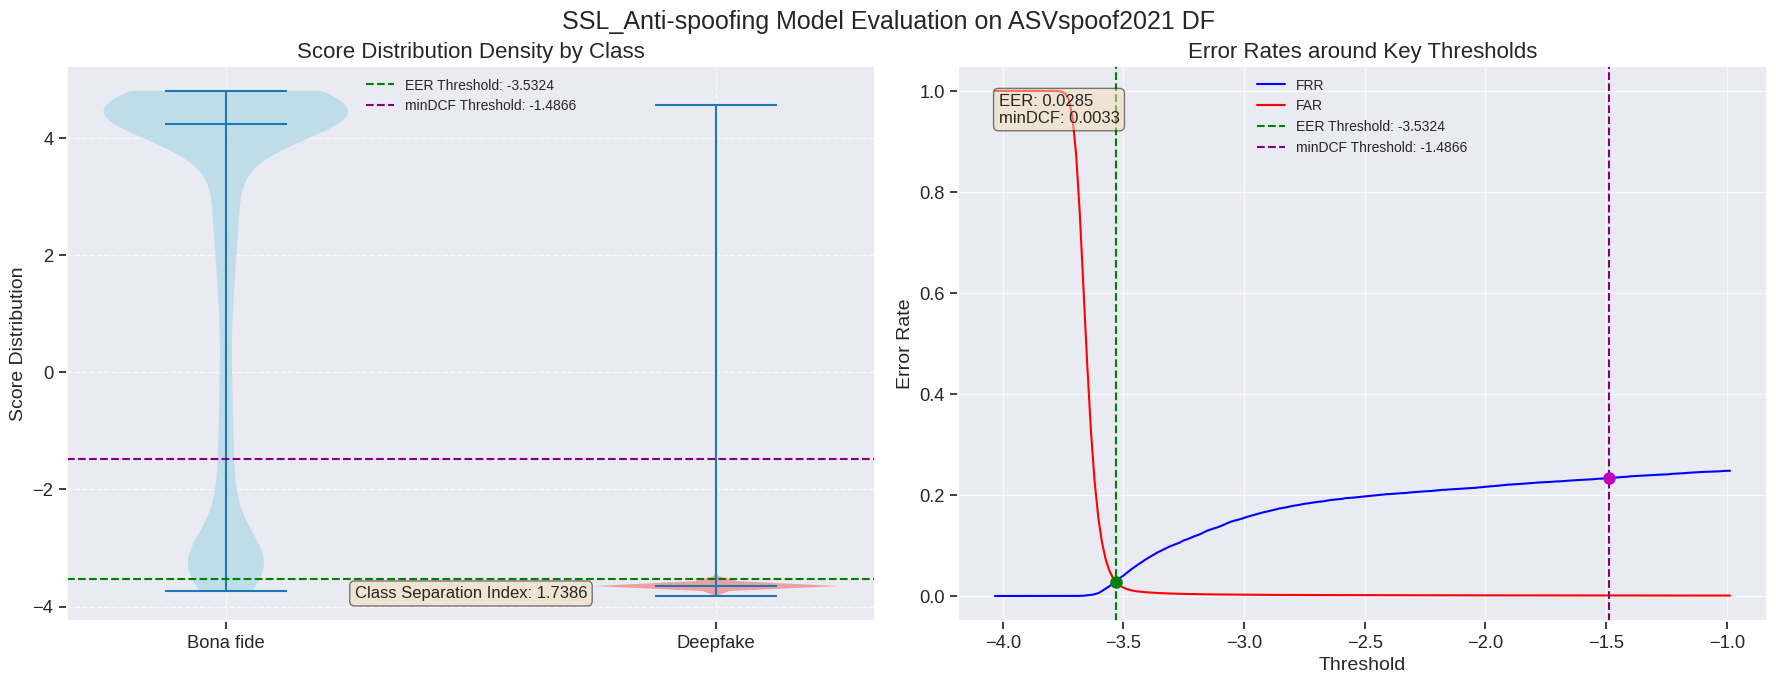

In [4]:
# Cell 3: Simplified Analysis with Essential Plots

def plot_simplified_analysis(target_scores, nontarget_scores, results):
    """
    Plot a simplified analysis focusing on the most important visualizations:
    1. Score Distribution Density by Class (with thresholds)
    2. Error Rates around key thresholds
    
    Args:
        target_scores: Array of scores for bona fide samples
        nontarget_scores: Array of scores for deepfake samples
        results: Dictionary of evaluation results
    """
    # Get thresholds from results
    eer_threshold = results['eer_threshold']
    min_dcf_threshold = results['min_dcf_threshold']
    
    # Create figure with two plots side by side
    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('SSL_Anti-spoofing Model Evaluation on ASVspoof2021 DF', fontsize=18)
    
    # Plot 1: Score Distribution Density by Class (Violin Plot with thresholds)
    ax = axs[0]
    
    # Create a violin plot
    parts = ax.violinplot([target_scores, nontarget_scores], showmedians=True)
    
    # Customize the violin plot
    parts['bodies'][0].set_facecolor('lightblue')
    parts['bodies'][0].set_alpha(0.7)
    parts['bodies'][1].set_facecolor('lightcoral')
    parts['bodies'][1].set_alpha(0.7)
    
    # Add thresholds as horizontal lines spanning the plot
    ax.axhline(y=eer_threshold, color='green', linestyle='--', 
               label=f'EER Threshold: {eer_threshold:.4f}')
    ax.axhline(y=min_dcf_threshold, color='purple', linestyle='--', 
               label=f'minDCF Threshold: {min_dcf_threshold:.4f}')
    
    # Set the labels
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Bona fide', 'Deepfake'])
    ax.set_ylabel('Score Distribution', fontsize=14)
    ax.set_title('Score Distribution Density by Class', fontsize=16)
    
    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    
    # Add statistical separation measure
    separation = np.abs(np.mean(target_scores) - np.mean(nontarget_scores)) / (np.std(target_scores) + np.std(nontarget_scores))
    ax.text(0.5, 0.05, f"Class Separation Index: {separation:.4f}",
            ha='center', va='center', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=12)
    
    # Plot 2: Error Rates around key thresholds
    ax = axs[1]
    
    # Generate threshold range to evaluate
    min_threshold = min(eer_threshold, min_dcf_threshold) - 0.5
    max_threshold = max(eer_threshold, min_dcf_threshold) + 0.5
    thresholds = np.linspace(min_threshold, max_threshold, 200)
    
    # Calculate FRR and FAR for each threshold
    frrs = []
    fars = []
    for threshold in thresholds:
        frr = np.sum(target_scores < threshold) / len(target_scores)
        far = np.sum(nontarget_scores >= threshold) / len(nontarget_scores)
        frrs.append(frr)
        fars.append(far)
    
    # Plot error rates
    ax.plot(thresholds, frrs, 'b-', label='FRR')
    ax.plot(thresholds, fars, 'r-', label='FAR')
    
    # Mark key thresholds
    ax.axvline(x=eer_threshold, color='green', linestyle='--', 
               label=f'EER Threshold: {eer_threshold:.4f}')
    ax.axvline(x=min_dcf_threshold, color='purple', linestyle='--', 
               label=f'minDCF Threshold: {min_dcf_threshold:.4f}')
    
    ax.set_xlabel('Threshold', fontsize=14)
    ax.set_ylabel('Error Rate', fontsize=14)
    ax.set_title('Error Rates around Key Thresholds', fontsize=16)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.7)
    
    # Mark the EER point
    eer_frr = np.sum(target_scores < eer_threshold) / len(target_scores)
    eer_far = np.sum(nontarget_scores >= eer_threshold) / len(nontarget_scores)
    ax.plot(eer_threshold, eer_frr, 'go', markersize=8)
    
    # Mark the minDCF point
    dcf_frr = np.sum(target_scores < min_dcf_threshold) / len(target_scores)
    dcf_far = np.sum(nontarget_scores >= min_dcf_threshold) / len(nontarget_scores)
    ax.plot(min_dcf_threshold, dcf_frr, 'mo', markersize=8)
    
    # Add text with key metrics
    textstr = '\n'.join((
        f'EER: {results["eer"]:.4f}',
        f'minDCF: {results["min_dcf"]:.4f}',
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)  # Make room for the suptitle
    plt.show()

# Plot simplified analysis
plot_simplified_analysis(target_scores, nontarget_scores, results)